Aim -
Develop a time series forecasting model to predict the demand for products in a retail store.

Description-
Use historical sales data to forecast future demand, considering seasonality and trends.

In [72]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
df_test = pd.read_csv('test.csv', parse_dates=['date'], index_col='date')
df_train

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [4]:
unique_store = df_train['store'].unique()
unique_item = df_train['item'].unique()
unique_sales = df_train['sales'].unique()
print(unique_store)
print(unique_item)
#print(unique_sales)

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [5]:
features =  df_train.columns.tolist()
print(features)

['store', 'item', 'sales']


In [6]:
def plotbarcharts(dataset,columns):
    %matplotlib inline
    fig,subplot = plt.subplots(nrows=1,ncols=len(columns),figsize=(18,5))
    fig.suptitle('Bar Chart for' + str(columns))
    for columnname,plotnumber in zip(columns,range(len(columns))):
        dataset.groupby(columnname).size().plot(kind='bar',ax=subplot[plotnumber])


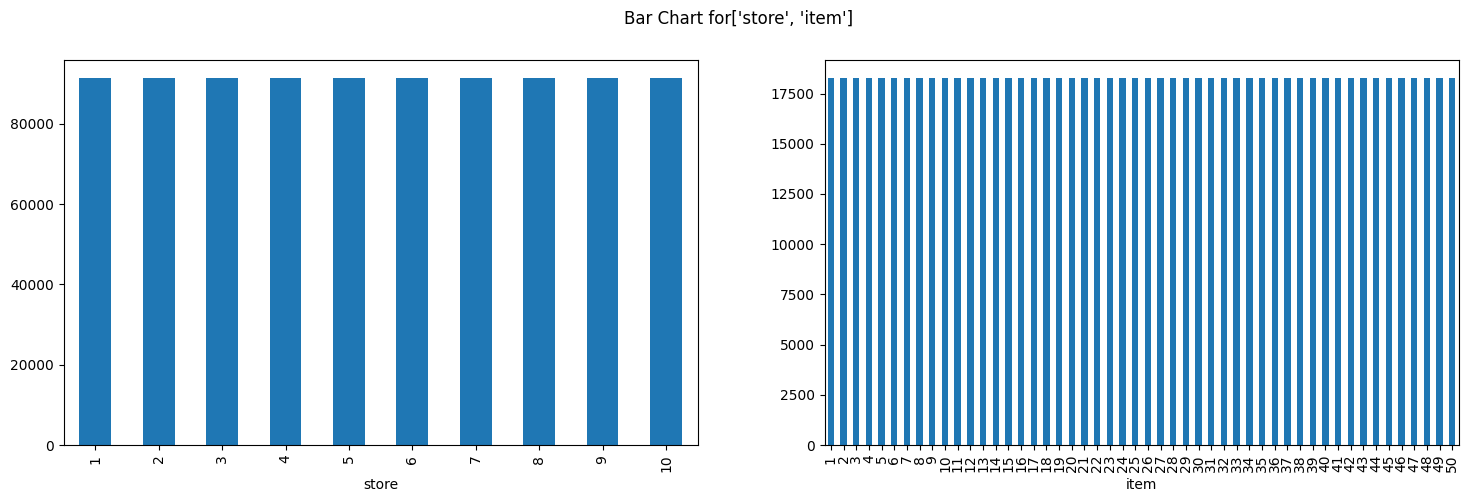

In [7]:
plotbarcharts(df_train, ['store','item'])

<Axes: xlabel='store'>

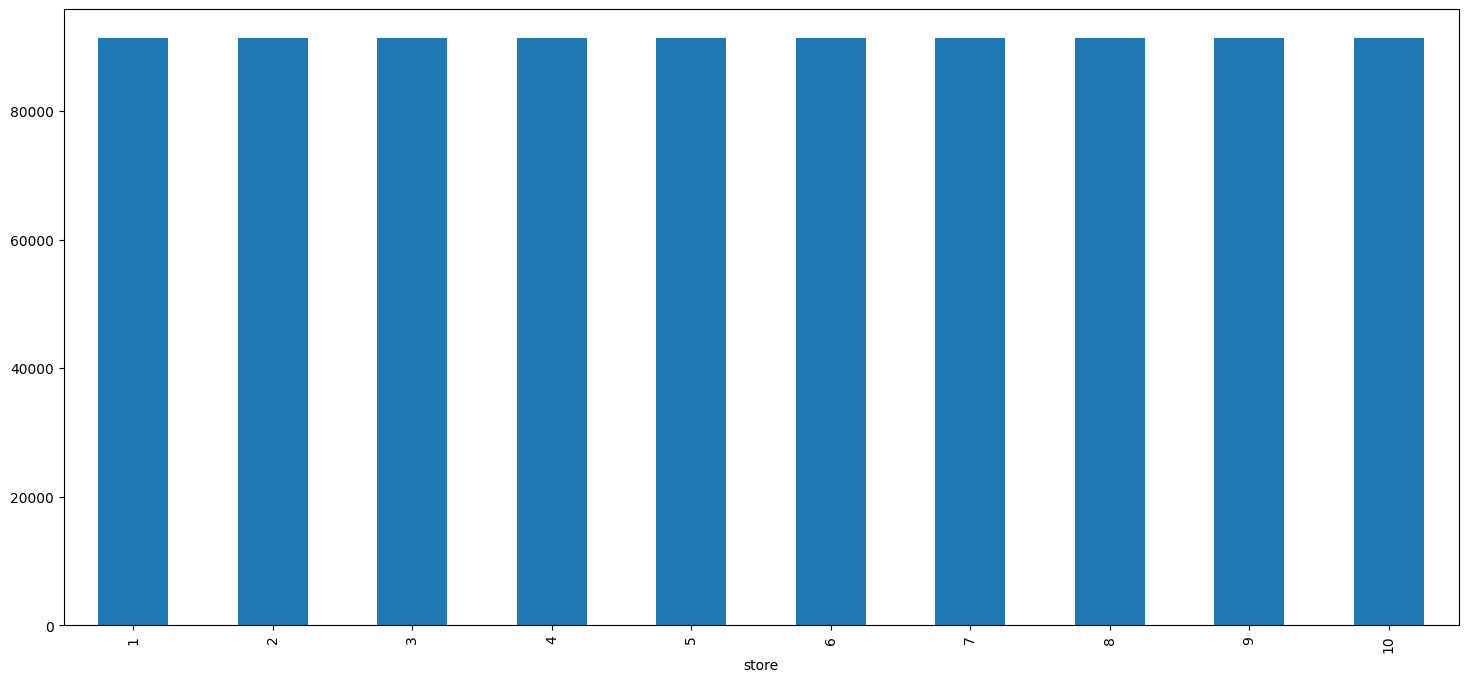

In [8]:
df_train.groupby(['store']).size().plot(kind='bar',figsize=(18,8))

In [9]:
def date_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    df = df.sort_index()
    return df

In [10]:
df_train = date_features(df_train)
df_test = date_features(df_test)

In [11]:
df_train.head()

,store,item,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,day^year
date,,,,,,,,,,,,
2013-01-01,1,1,13,0,1,1,1,2013,1,1,1,-4.764668
2013-01-01,7,12,26,0,1,1,1,2013,1,1,1,-4.764668
2013-01-01,7,46,27,0,1,1,1,2013,1,1,1,-4.764668
2013-01-01,8,12,54,0,1,1,1,2013,1,1,1,-4.764668
2013-01-01,9,12,35,0,1,1,1,2013,1,1,1,-4.764668


In [12]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_train = df_train.dropna()
df_test = df_test.dropna()
print(df_train.shape)
print(df_test.shape)

(913000, 12)
(45000, 12)


<Axes: xlabel='date'>

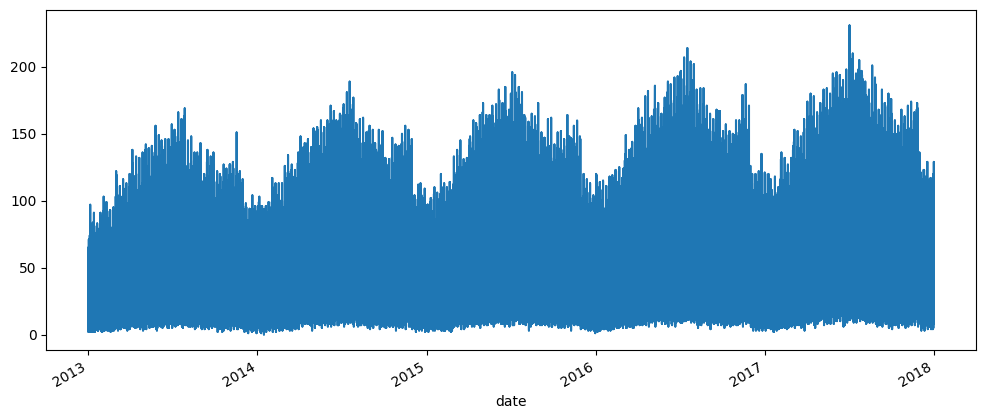

In [13]:
df_train['sales'].plot(figsize=(12,5))

<Axes: xlabel='year'>

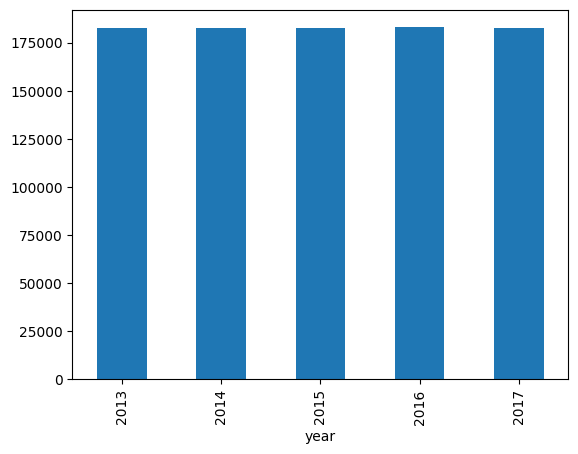

In [14]:
df_train.groupby(['year']).size().plot(kind='bar')

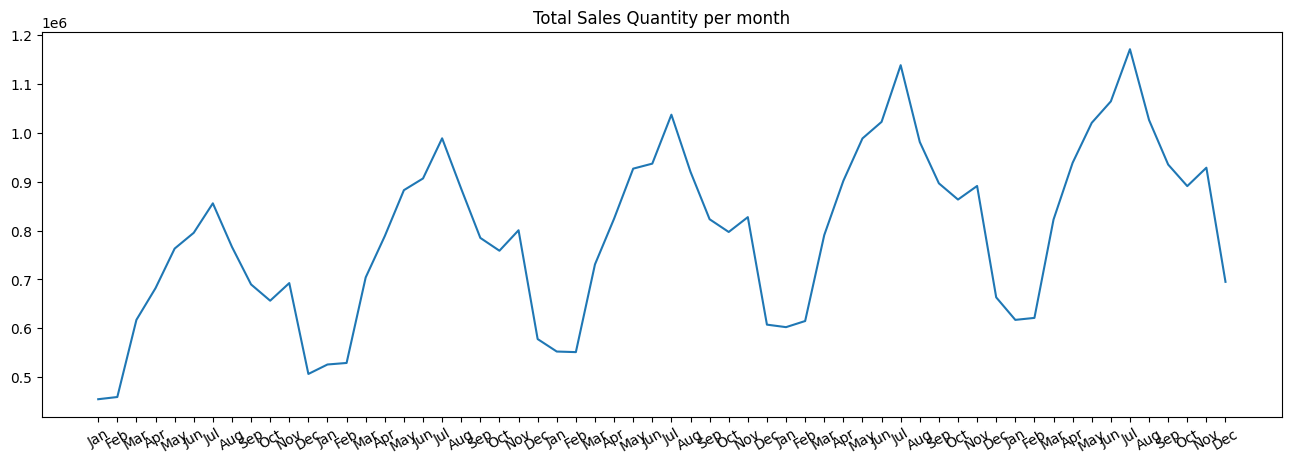

In [15]:
a = pd.crosstab(columns=df_train['month'],
            index=df_train['year'],
            values=df_train['sales'],
            aggfunc='sum')

SalesQuantity=pd.crosstab(columns=df_train['year'],
            index=df_train['month'],
            values=df_train['sales'],
            aggfunc='sum').melt()['value']

MonthNames=['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep','Oct','Nov','Dec']*5

# Plotting the sales
%matplotlib inline
SalesQuantity.plot(kind='line', figsize=(16,5), title='Total Sales Quantity per month')
# Setting the x-axis labels
plotLabels=plt.xticks(np.arange(0,60,1),MonthNames, rotation=30)

In [16]:
SalesQuantity

0      454904
1      459417
2      617382
3      682274
4      763242
5      795597
6      855922
7      766761
8      689907
9      656587
10     692643
11     506607
12     525987
13     529117
14     704301
15     788914
16     882877
17     906842
18     989010
19     885596
20     785124
21     758883
22     800783
23     578048
24     552513
25     551317
26     730951
27     824467
28     926902
29     937184
30    1037350
31     920401
32     823332
33     797253
34     827645
35     607572
36     602439
37     614957
38     790881
39     901950
40     988730
41    1022664
42    1138718
43     981494
44     896831
45     863637
46     891448
47     663411
48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: value, dtype: int64

In [17]:
a

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2013,454904,459417,617382,682274,763242,795597,855922,766761,689907,656587,692643,506607
2014,525987,529117,704301,788914,882877,906842,989010,885596,785124,758883,800783,578048
2015,552513,551317,730951,824467,926902,937184,1037350,920401,823332,797253,827645,607572
2016,602439,614957,790881,901950,988730,1022664,1138718,981494,896831,863637,891448,663411
2017,617306,621369,822667,938862,1020686,1064624,1171393,1026403,935263,891160,928837,695170


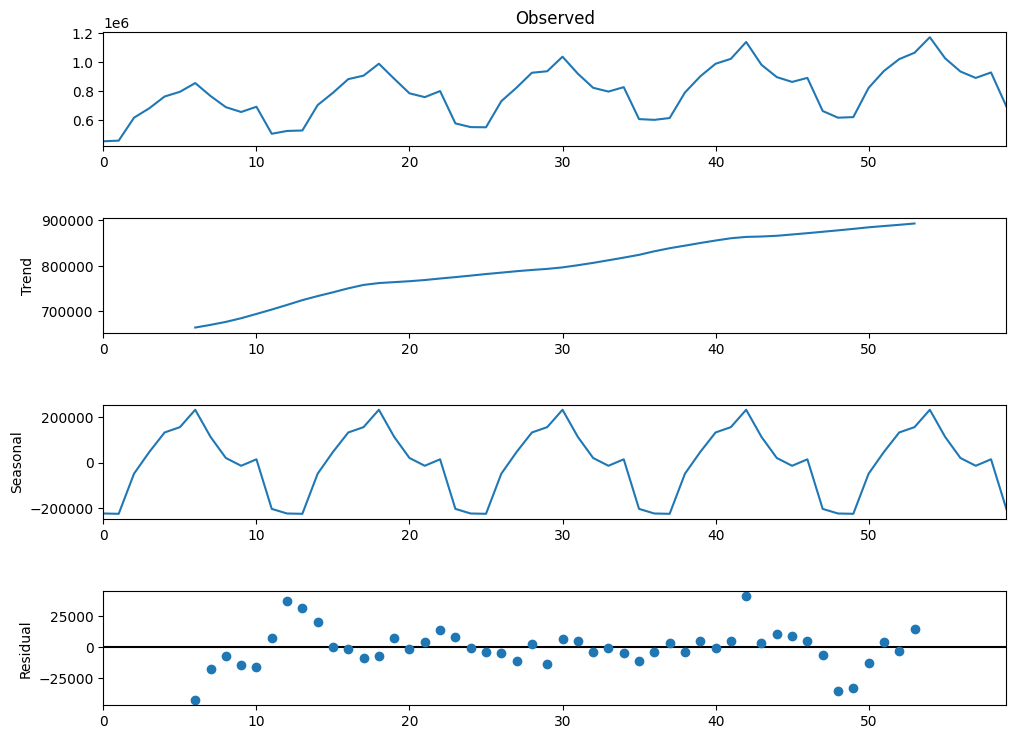

In [18]:
series = SalesQuantity.values
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
CurrentFig = plt.gcf()
CurrentFig.set_size_inches(11, 8)
plt.show()

In [19]:
'''Augmented Dickey Fuller test is done to check the stationarity in the time series data. If there is stationarity,
we need to remove that to apply models like ARIMA etc.'''

def adf_test(series):
    dftest = adfuller(series, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)



In [20]:
adf_test(SalesQuantity)

1. ADF :  -5.247518850016353
2. P-Value :  7.026495391574688e-06
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression: 48
5. Critical Values :
	 1% :  -3.5745892596209488
	 5% :  -2.9239543084490744
	 10% :  -2.6000391840277777


In [21]:
'''Here, after ADF test, its found that the data is stationary as the p-value is less than 0.05'''

'Here, after ADF test, its found that the data is stationary as the p-value is less than 0.05'

In [73]:
# Split the data into training and validation sets
train = df_train.loc[df_train.index < '2017-06-01']
val = df_train.loc[df_train.index >= '2017-06-01']

In [24]:
train = SalesQuantity[:-6]
val = SalesQuantity[-6:]

In [25]:
print(train.shape)
print(val.shape)

(54,)
(6,)


In [26]:
# Perform auto ARIMA
stepwise_fit = auto_arima(SalesQuantity, trace=True, suppress_warnings=True, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1042.823, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1051.141, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1041.111, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1040.606, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1053.090, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1039.926, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1041.152, Time=0.03 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1042.252, Time=0.06 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1042.965, Time=0.06 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1037.702, Time=0.25 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1034.146, Time=0.21 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[12]          

In [59]:
model = ARIMA(train, order=stepwise_fit.order)
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   54
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -687.328
Date:                Mon, 22 Jul 2024   AIC                           1376.656
Time:                        03:18:26   BIC                           1378.627
Sample:                             0   HQIC                          1377.414
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.056e+10   2.21e+09      4.785      0.000    6.23e+09    1.49e+10
Ljung-Box (L1) (Q):                   3.20   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.07   Pr

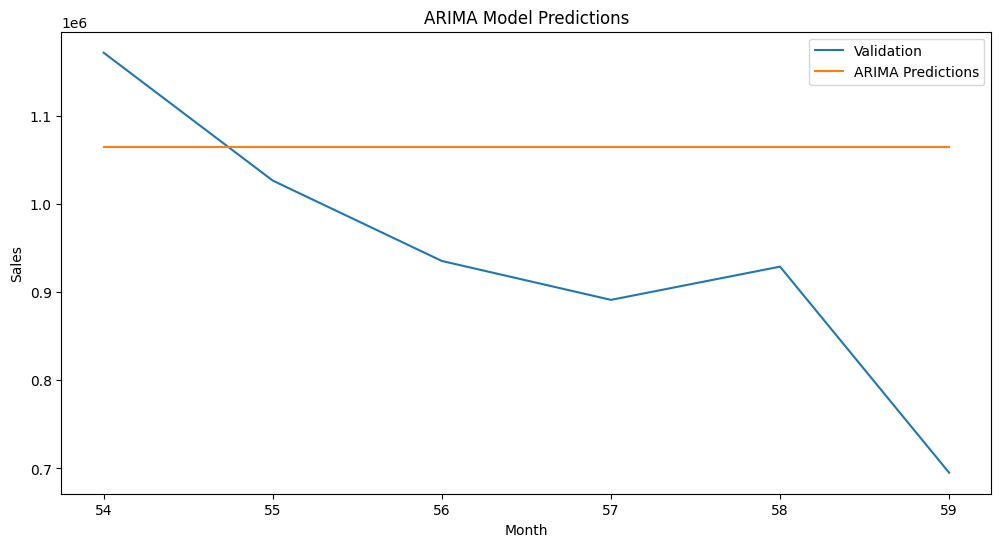

In [60]:
# Predict
start = len(train)
end = len(train) + len(val) - 1
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(val, label='Validation')
plt.plot(pred, label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [61]:
rmse=sqrt(mean_squared_error(pred,val))
print(rmse)

189129.08259704534


In [62]:
result = pd.DataFrame()

In [63]:
result['Validation'] = val

In [64]:
result['Prediction'] = pred

In [65]:
result.index = pd.RangeIndex(start=1, stop=len(result) + 1, step=1)
result = result.astype(int)
print(result)

   Validation  Prediction
1     1171393     1064624
2     1026403     1064624
3      935263     1064624
4      891160     1064624
5      928837     1064624
6      695170     1064624


In [66]:
model = SARIMAX(train, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
model = model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51105D+00    |proj g|=  2.14332D+00

At iterate    5    f=  8.30640D+00    |proj g|=  2.51973D-01

At iterate   10    f=  8.29217D+00    |proj g|=  9.37556D-03

At iterate   15    f=  8.29208D+00    |proj g|=  1.84269D-03

At iterate   20    f=  8.29171D+00    |proj g|=  2.30978D-02

At iterate   25    f=  8.29166D+00    |proj g|=  6.64425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   

 This problem is unconstrained.


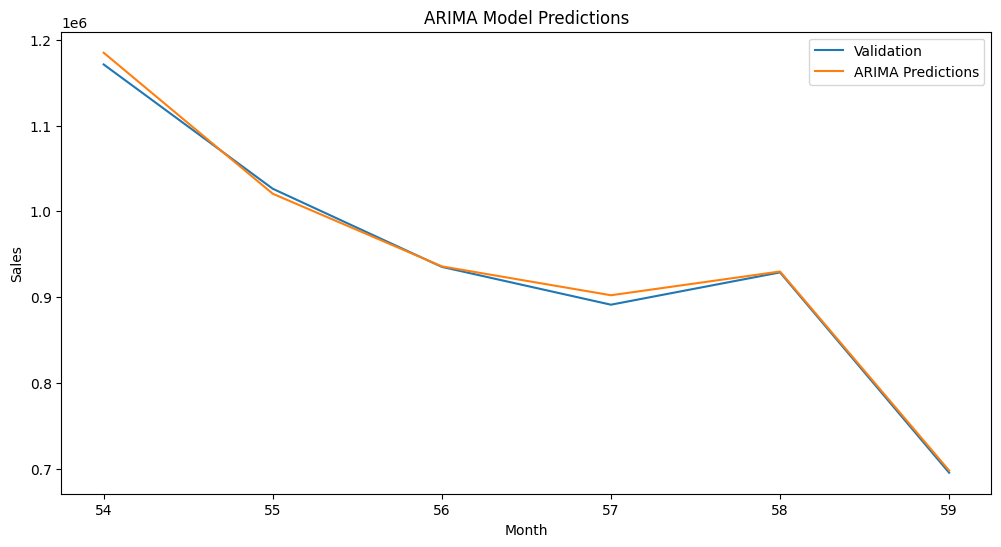

In [67]:
# Predict
start = len(train)
end = len(train) + len(val) - 1
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(val, label='Validation')
plt.plot(pred, label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [68]:
rmse=sqrt(mean_squared_error(pred,val))
print(rmse)

7643.823858109459


In [69]:
result = pd.DataFrame()
result.index = pd.RangeIndex(start=1, stop=len(result) + 1, step=1)
result['Validation'] = val
result['Prediction'] = pred
result = result.astype(int)
print(result)

    Validation  Prediction
54     1171393     1185071
55     1026403     1020577
56      935263      935863
57      891160      902181
58      928837      929894
59      695170      697737
